# Quora Questions Classification Based on Word Vectors
## using Spacy with vectors only statistical model en_vectors_web_lg
## and sklearn logistic regression


In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'spacy_vectors_logistic')

In [3]:
quora = pd.read_csv('../data/.input/train.csv', nrows=20_000)

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [6]:
import spacy

nlp = spacy.load('en_vectors_web_lg', disable=["parser", "ner"])

In [7]:
from tqdm import tqdm
import numpy as np


X = np.array([nlp(text).vector for text in tqdm(quora.question_text)])
y = quora.target

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1412.32it/s]


In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def report_results(clf, test_X, test_y):
    test_predict_proba = clf.predict_proba(test_X)
    test_predict_proba_pos = test_predict_proba[:, 1]
    auc = roc_auc_score(test_y, test_predict_proba_pos)
    curve = roc_curve(test_y, test_predict_proba_pos)


    plt.plot(curve[0], curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);
    
    to_labels = np.vectorize(lambda x: 1 if x > 0.5 else 0)
    test_predict = to_labels(test_predict_proba_pos)

    print('accuracy', accuracy_score(test_y, test_predict))
    print('precision', precision_score(test_y, test_predict))
    print('recall', recall_score(test_y, test_predict))
    print('f1', f1_score(test_y, test_predict))
    print('AUC', auc)
    confusion_matrix(test_y, test_predict)


## Logistic Regression

In [10]:
%%time

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='saga', C = 0.5, class_weight='balanced', random_state=42, max_iter=500)
clf.fit(train_X, train_y)

Wall time: 4.57 s


accuracy 0.8622
precision 0.2806236080178174
recall 0.8542372881355932
f1 0.4224643755238894
AUC 0.9247140618526991


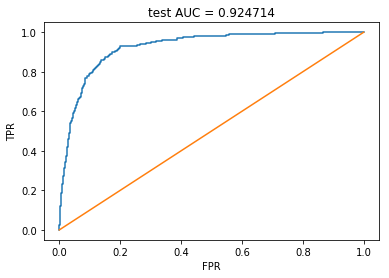

In [11]:
report_results(clf, test_X, test_y)

## Grid Search

In [12]:
%%time

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

params_grid = [{'solver': ['saga'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']},
               {'solver': ['newton-cg', 'sag'], 'C': [0.1, 0.5, 5.0], 'class_weight': [None, 'balanced'], 'penalty': ['l2']}]

clf = LogisticRegression(random_state=42, max_iter=500)

grid_search = GridSearchCV(clf, params_grid, cv=5, return_train_score=True, scoring='f1', n_jobs=-1)

grid_search.fit(train_X, train_y)

c:\users\alexa\.virtualenvs\ml-awwz4wov\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 7min 43s


In [13]:
for score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
        print(score, params)

print('\nbest params', grid_search.best_params_)

0.1655695508262213 {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.2642005731010116 {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.42596035211959704 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.43952553670176653 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.36512696484910806 {'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.3718456815706634 {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.4300796982153718 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.4490167902547453 {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
0.43323892022806454 {'C': 5.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
0.42949644352014316 {'C': 5.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
0.45652650202506523 {'C': 5.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
0.40875

accuracy 0.9268
precision 0.41277641277641275
recall 0.5694915254237288
f1 0.4786324786324786
AUC 0.9163407121886201


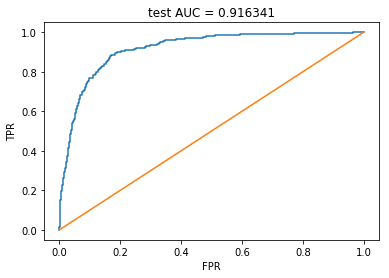

In [14]:
report_results(grid_search.best_estimator_, test_X, test_y)